In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   -- ------------------------------------- 10.5/150.0 MB 59.4 MB/s eta 0:00:03
   ------ --------------------------------- 22.5/150.0 MB 57.0 MB/s eta 0:00:03
   -------- ------------------------------- 32.8/150.0 MB 54.7 MB/s eta 0:00:03
   ---------- ----------------------------- 40.6/150.0 MB 49.7 MB/s eta 0:00:03
   ------------- -------------------------- 49.0/150.0 MB 47.2 MB/s eta 0:00:03
   --------------- ------------------------ 56.6/150.0 MB 45.1 MB/s eta 0:00:03
   ----------------- ---------------------- 64.7/150.0 MB 43.9 MB/s eta 0:00:02
   ------------------- -------------------- 71.3/150.0 MB 42.1 MB/s eta 0:00:02
   -------------------- ------------------- 77.3/150.0 MB 40.8 MB/s eta 0:00:02
   ---------------------- ----------------- 83.9/150.0 MB 39.6 MB/s eta 0:00:02
   ------------------------ --------------- 91.0/150.0 MB 38.9 MB/s eta 0:00:02
   -------------------------- ------------- 98.8/


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


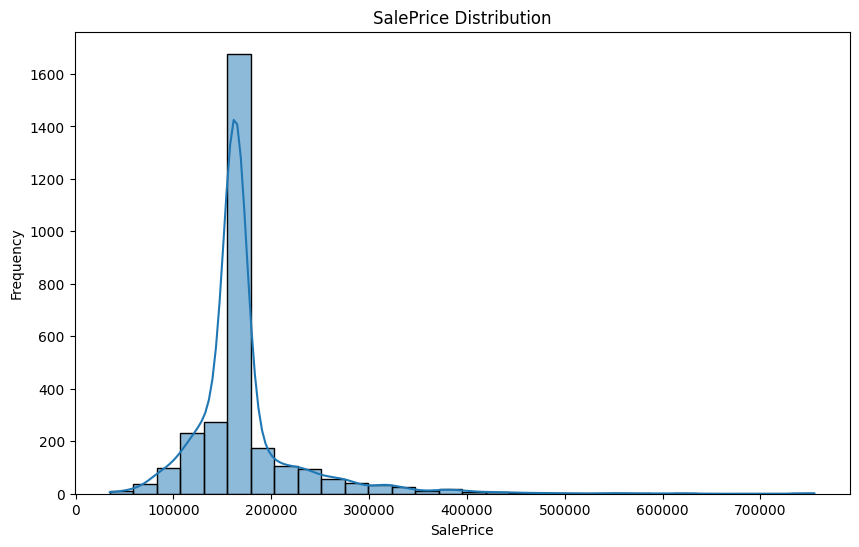

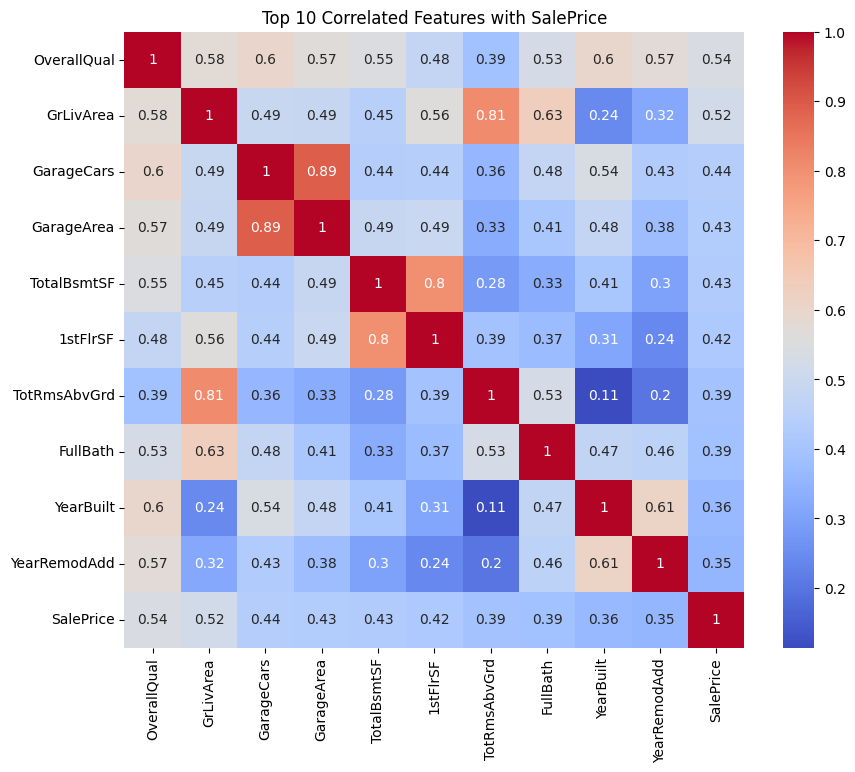

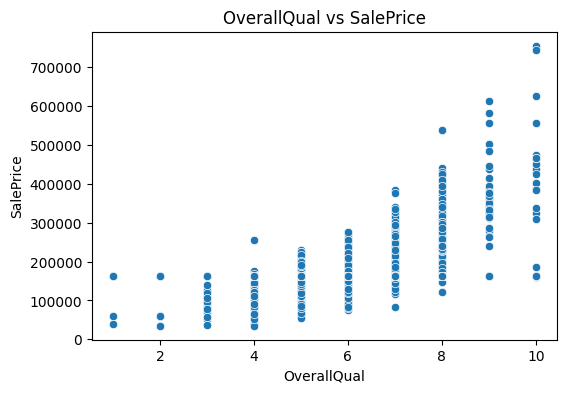

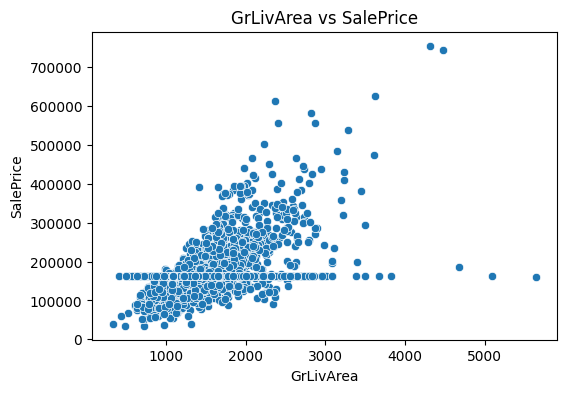

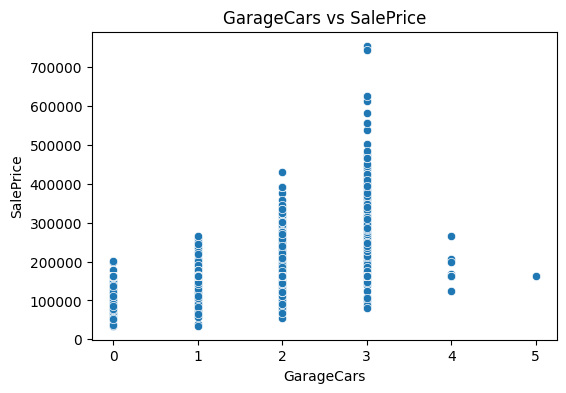

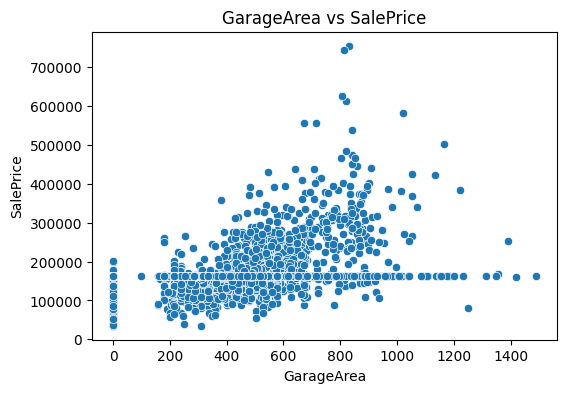

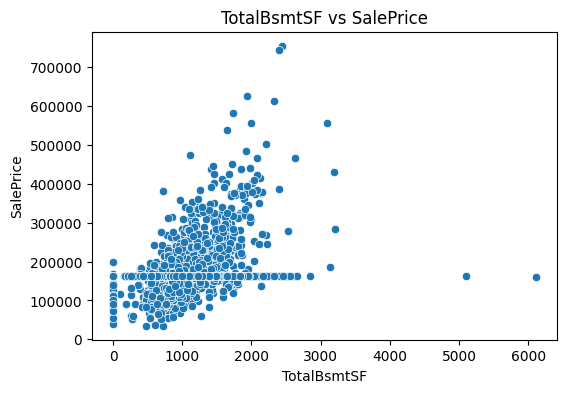

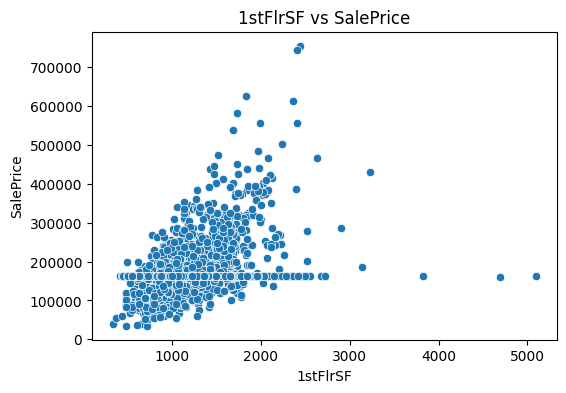

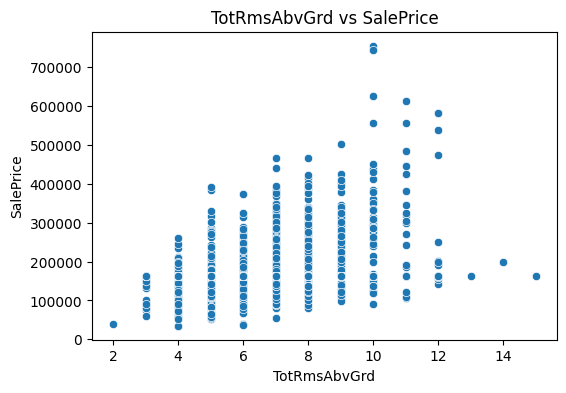

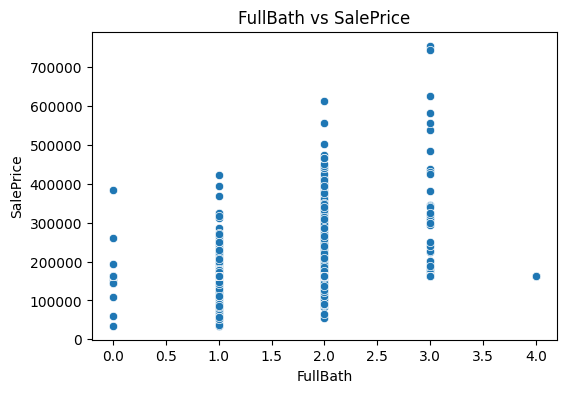

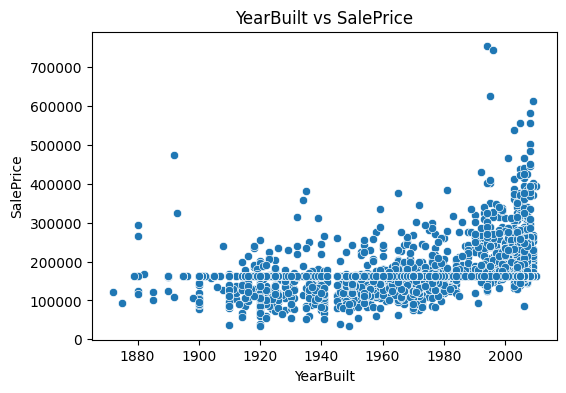

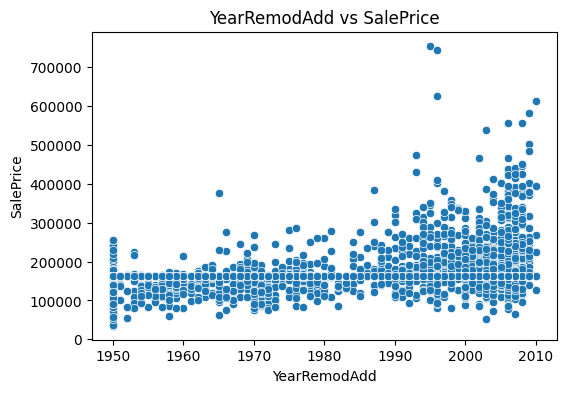

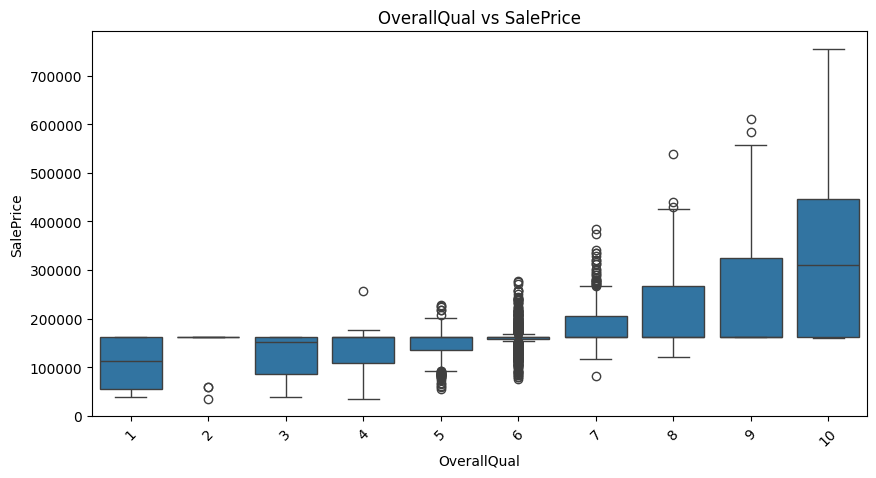

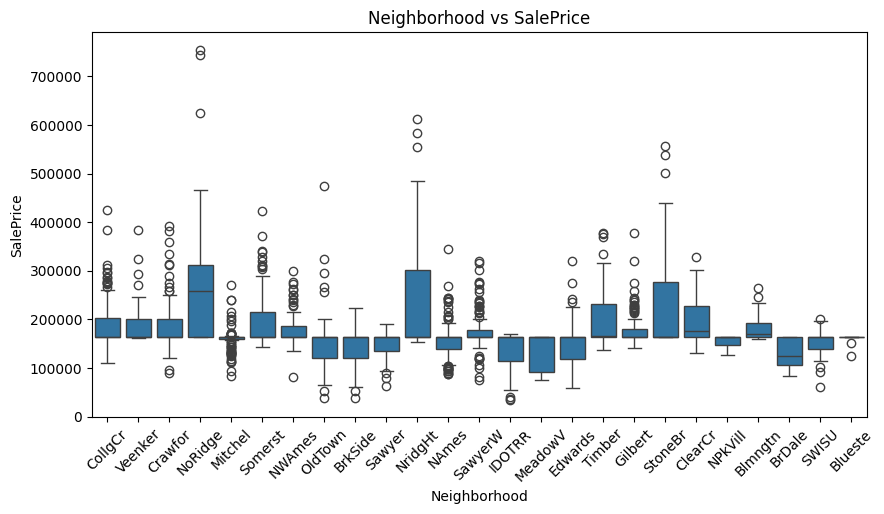

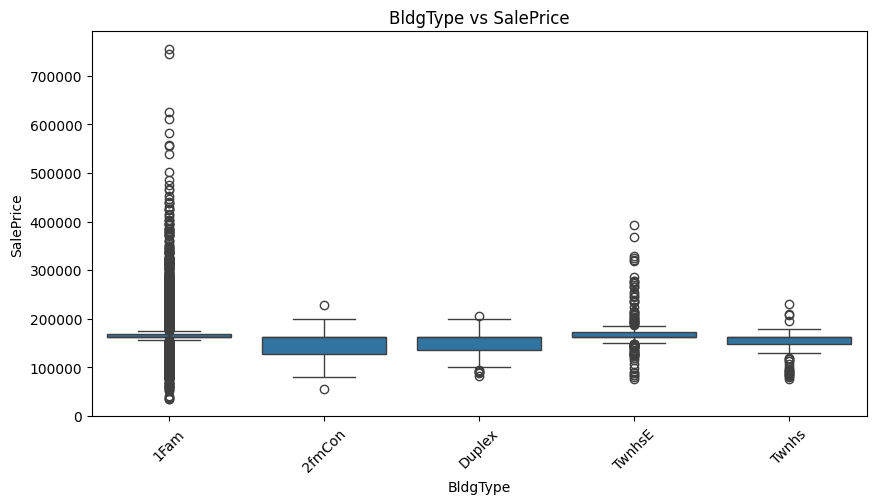

Test shape after encoding and alignment: (1459, 288)

Model Comparison:
              Model  R2 Score          RMSE           MAE
4  GradientBoosting  0.906773  26740.984648  16649.203414
5           XGBoost  0.900140  27675.963190  17384.970436
2             Lasso  0.896056  28236.273082  17916.499388
3      RandomForest  0.889229  29148.749028  17747.235308
0  LinearRegression  0.886727  29476.125983  18285.740789
1             Ridge  0.883954  29834.679517  18998.797447


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import os

# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load data
train = pd.read_csv("../../../Dataset/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../../../Dataset/house-prices-advanced-regression-techniques/test.csv")
test_ids = test["Id"]  # Save Ids for submission

# Save number of rows
n_train = train.shape[0]
n_test = test.shape[0]

# Combine for preprocessing
df = pd.concat([train, test], sort=False).reset_index(drop=True)

# Handling missing values
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# EDA Visualizations
if 'SalePrice' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['SalePrice'], kde=True, bins=30)
    plt.title("SalePrice Distribution")
    plt.xlabel("SalePrice")
    plt.ylabel("Frequency")
    plt.show()

    # Compute correlation only on numeric columns
    corr_matrix = df[num_cols].corr()
    top_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)[1:11]
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[top_corr.index.tolist() + ['SalePrice']].corr(), annot=True, cmap='coolwarm')
    plt.title("Top 10 Correlated Features with SalePrice")
    plt.show()

    for col in top_corr.index.tolist():
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col], y=df['SalePrice'])
        plt.title(f"{col} vs SalePrice")
        plt.xlabel(col)
        plt.ylabel("SalePrice")
        plt.show()

    for col in ['OverallQual', 'Neighborhood', 'BldgType']:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col], y=df['SalePrice'])
        plt.xticks(rotation=45)
        plt.title(f"{col} vs SalePrice")
        plt.show()

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df)

# Split into train and test sets based on original row counts
train_encoded = df_encoded.iloc[:n_train]
test_encoded = df_encoded.iloc[n_train:].drop('SalePrice', axis=1)

X = train_encoded.drop("SalePrice", axis=1)
y = train_encoded["SalePrice"]

# Align test columns with train columns
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

# Ensure test_encoded has the right number of rows
print("Test shape after encoding and alignment:", test_encoded.shape)
assert test_encoded.shape[0] == n_test, "Mismatch in test prediction rows"

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    results.append({"Model": name, "R2 Score": r2, "RMSE": rmse, "MAE" : mae})

results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print("\nModel Comparison:")
print(results_df)

# Best model prediction on test set
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X, y)
test_preds = best_model.predict(test_encoded)
